In [1]:
# Standard libraries
from copy import deepcopy

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from scipy.stats import mannwhitneyu, wilcoxon

# User libraries
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.stat.machinelearning import binary_classifier
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.stat.connectomics import offdiag_1D
from mesostat.utils.plotting import imshow

from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
from src.lib.metric_wrapper import metric_by_interval, metric_by_phase
from src.lib.extra_metrics import num_non_zero_std, num_sample
from src.lib.stat_lib import cluster_dist_matrix


%load_ext autoreload
%autoreload 2

Appended root directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-neuro/chernysheva-tmaze-analysis-2020


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
# params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
# params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [3]:
dataDB = BehaviouralNeuronalDatabase(params)

In [4]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [5]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


# 1. Neuron-Time-Average

**Goal**: Attempt to predict phase from mean activity over trial

# 2 Time-Average

**Goal**: Attempt to predict phase from average activities of individual cells.
* Count predictive cells in each mouse
* Test overlap over phases/intervals - identify how many significant cells overlap

## 2.1 avg-firing-rate by neuron and interval
 -> heatmap by mouse | 1D plot by neurons

In [47]:
settings = {"zscoreChannel" : False, "serial" : True, "metricSettings" : {}}

for mousename in dataDB.mice:
    fig, ax = plt.subplots(ncols=4, figsize=(4*2, 6))
    fig.suptitle(mousename)
    iCol = 0
    
    for performance in ['Correct', 'Mistake']:
        boundingLines = dataDB.get_phase_bounding_lines(performance)
        
        for direction in ['L', 'R']:
            queryDict = {'datatype' : 'deconv', 'mousename' : mousename, 'performance' : performance, 'direction' : direction}
            rez2D = metric_by_interval(dataDB, queryDict, 'mean', 'p', settings)
            rez2D = rez2D.T
#             rez2D = rez2D[np.argsort(np.mean(rez2D, axis=1))[::-1]]
#             rez2Dnorm = np.array([r / np.max(r) for r in rez2D])
            
            ax[iCol].imshow(rez2D, vmin=0, vmax=0.6)
            imshow(fig, ax[iCol], rez2D, limits=[0, 0.6], title=str([direction, performance]), haveColorBar=True)
        
            for bline in boundingLines:
                ax[iCol].axvline(x=bline-0.5, linestyle='--', color='r', alpha=0.5)
            
            iCol += 1
            
    plt.savefig(mousename + '_avgrate_interval.svg')
    plt.close()

No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance'

# 2.2 avg-firing-rate by neuron and phase

In [48]:
settings = {"zscoreChannel" : False, "serial" : True, "metricSettings" : {}}

for mousename in dataDB.mice:
    fig, ax = plt.subplots(ncols=4, figsize=(4*2, 6))
    fig.suptitle(mousename)
    iCol = 0
    
    for performance in ['Correct', 'Mistake']:
        for direction in ['L', 'R']:
            queryDict = {'datatype' : 'deconv', 'mousename' : mousename, 'performance' : performance, 'direction' : direction}
            rez2D = metric_by_phase(dataDB, queryDict, 'mean', 'p', settings)
            rez2D = rez2D.T

            imshow(fig, ax[iCol], rez2D, limits=[0, 0.6], title=str([direction, performance]), haveColorBar=True)
            
            iCol += 1
            
    plt.savefig(mousename + '_avgrate_phase.svg')
    plt.close()

No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance'

## 2.3 significant-avg-firing-rate by neuron and interval

In [10]:
def test_greater_one(data2D, i):
    dataThis = data2D[i]
    dataOther = np.hstack([data2D[:i].flatten(), data2D[i+1:].flatten()])
    T, p = mannwhitneyu(dataThis, dataOther, alternative="greater")
    return -np.log10(p)


def text_greater(data2D):
    return np.array([test_greater_one(data2D, i) for i in range(len(data2D))])


# Calculate confusion matrix
def significance_confusion_matrix(sign2D):
    nCell, nPhase = sign2D.shape  # A boolean array reporting if a given cell is significant in a given phase
    confMat = np.zeros((nPhase, nPhase))
    for i in range(nPhase):
        for j in range(nPhase):
            confMat[i][j] = np.sum(np.logical_and(sign2D[:, i], sign2D[:, j]))
    return confMat

In [14]:
settings = {"zscoreChannel" : False, "serial" : True, "metricSettings" : {}}

for mousename in sorted(dataDB.mice):
    print('doing mouse', mousename)
    
    fig1, ax1 = plt.subplots(ncols=4, figsize=(4*2, 6), tight_layout=True)
    fig2, ax2 = plt.subplots(ncols=4, figsize=(4*4, 4), tight_layout=True)
    
    fig1.suptitle(mousename)
    fig2.suptitle(mousename)
    iCol = 0
    
    for performance in ['Correct', 'Mistake']:
        boundingLines = dataDB.get_phase_bounding_lines(performance)
        
        for direction in ['L', 'R']:
            queryDict = {'datatype' : 'deconv', 'mousename' : mousename, 'performance' : performance, 'direction' : direction}
            rez3D = metric_by_interval(dataDB, queryDict, 'mean', 'pr', settings)
            
            nInterval, nChannel, nTrial = rez3D.shape
            pVals2D = np.array([text_greater(rez3D[:, iChannel]) for iChannel in range(nChannel)])
            
            # Sort by max argument
            idxsMaxArgs = np.argsort(np.array([np.argmax(p) for p in pVals2D]))
            pVals2D = pVals2D[idxsMaxArgs]
            
            imshow(fig1, ax1[iCol], pVals2D, limits=[-4, 4], title=str([direction, performance]), haveColorBar=True, cmap='jet')
            for bline in boundingLines:
                ax1[iCol].axvline(x=bline-0.5, linestyle='--', color='r', alpha=0.5)
                                
            # Calculate confusion matrix
            sign2D = pVals2D > 2
            confMat = significance_confusion_matrix(sign2D)
                    
            # Plot confusion matrix
            imshow(fig2, ax2[iCol], confMat, limits=[0, nChannel], title=str([direction, performance]), haveColorBar=True, cmap='jet')
            
            iCol += 1
            
    fig1.savefig(mousename + '_significantrate_interval.svg')
    plt.close()
    fig2.savefig(mousename + '_significantrate_interval_confusion.svg')
    plt.close()

doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found f

## 2.4 significant-avg-firing-rate by neuron and phase

In [28]:
settings = {"zscoreChannel" : False, "serial" : True, "metricSettings" : {}}

significantCellsMaintenance = {}

for mousename in sorted(dataDB.mice):
    print('doing mouse', mousename)
    
    fig1, ax1 = plt.subplots(ncols=4, figsize=(4*1, 6), tight_layout=True)
    fig2, ax2 = plt.subplots(ncols=4, figsize=(4*4, 4), tight_layout=True)
    
    fig1.suptitle(mousename)
    fig2.suptitle(mousename)
    iCol = 0
    
    for performance in ['Correct', 'Mistake']:
        for direction in ['L', 'R']:
            queryDict = {'datatype' : 'deconv', 'mousename' : mousename, 'performance' : performance, 'direction' : direction}
            rez3D = metric_by_phase(dataDB, queryDict, 'mean', 'pr', settings)
            
            nPhase, nChannel, nTrial = rez3D.shape
            pVals2D = np.array([text_greater(rez3D[:, iChannel]) for iChannel in range(nChannel)])
            
            # Sort by max argument
            idxsMaxArgs = np.argsort(np.array([np.argmax(p) for p in pVals2D]))
            pVals2D = pVals2D[idxsMaxArgs]            
            
            # Plot log-pvalues
            imshow(fig1, ax1[iCol], pVals2D, limits=[0, 4], title=str([direction, performance]), haveColorBar=False, cmap='jet')
            
            # Calculate confusion matrix
            sign2D = pVals2D > 2
            confMat = significance_confusion_matrix(sign2D)
            
            # Store cells that are significant in maintenance
            cellsEncoding = set(np.where(sign2D[:, 0])[0])
            cellsMaintenance = set(np.where(sign2D[:, 1])[0])
            cellsRetrieval = set(np.where(sign2D[:, 2])[0])
            cellsMaintenanceOnly = list(cellsMaintenance - cellsEncoding - cellsRetrieval)
            cellsMaintenanceOnly = [int(elem) for elem in cellsMaintenanceOnly]
            significantCellsMaintenance[str([mousename, performance, direction])] = cellsMaintenanceOnly
            
            print("Significant cells:", cellsMaintenanceOnly)
                    
            # Plot confusion matrix
            imshow(fig2, ax2[iCol], confMat, limits=[0, nChannel], title=str([direction, performance]), haveColorBar=True, cmap='jet')
            
            iCol += 1
            
    fig1.savefig(mousename + '_significantrate_phase.svg')
    plt.close()
    fig2.savefig(mousename + '_significantrate_phase_confusion.svg')
    plt.close()
    
with open('significant_cells_maintenance.json', 'w') as fp:
    json.dump(significantCellsMaintenance, fp, indent=4)

doing mouse m060
Significant cells: [16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 47, 61, 63, 66, 67, 69, 71, 73, 75, 76, 81, 82, 85, 87]
Significant cells: [16, 17, 18, 19, 20, 21, 22, 26, 28, 29, 30, 31, 48, 49, 50, 52, 55, 56, 60, 61, 63, 64, 65, 66, 67, 72, 73, 75, 76, 77, 78, 82, 86, 87]
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
Significant cells: [27]
Significant cells: [35, 38, 73, 14, 15, 80, 17, 18, 19, 20, 81, 22, 23, 83, 25, 84, 86, 29]
doing mouse m061
Significant cells: [8, 9, 10, 11, 13, 15, 16, 17, 18, 21, 28, 29, 30, 32, 33, 35, 36, 

# 3.1 Table - Discriminate Phases by Metric

In [7]:
%%time
dataDB.verbose = False

phases = ['Encoding', 'Maintenance', 'Retrieval']
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}
settings = {"serial" : True, "metricSettings" :{"max_lag" : 1}}
sweepDict = {
    "mousename" : sorted(list(dataDB.mice)),
    "datatype": ["deconv"], #["raw", "high", "deconv"],
    "performance": ["Correct"], #["Correct", "Mistake", "All"],
    "direction": ["L", "R", "All"]
}

plots_lib.table_discriminate_phases(dataDB, sweepDict,
                                         phases,
                                         "mean",
                                         trgDimOrder="r",
                                         settings=settings)

{'mousename': 'm060', 'datatype': 'deconv', 'performance': 'Correct', 'direction': 'L'}
{'mousename': 'm060', 'datatype': 'deconv', 'performance': 'Correct', 'direction': 'R'}
{'mousename': 'm060', 'datatype': 'deconv', 'performance': 'Correct'}
{'mousename': 'm061', 'datatype': 'deconv', 'performance': 'Correct', 'direction': 'L'}
{'mousename': 'm061', 'datatype': 'deconv', 'performance': 'Correct', 'direction': 'R'}
{'mousename': 'm061', 'datatype': 'deconv', 'performance': 'Correct'}
{'mousename': 'm065', 'datatype': 'deconv', 'performance': 'Correct', 'direction': 'L'}
{'mousename': 'm065', 'datatype': 'deconv', 'performance': 'Correct', 'direction': 'R'}
{'mousename': 'm065', 'datatype': 'deconv', 'performance': 'Correct'}
{'mousename': 'm066', 'datatype': 'deconv', 'performance': 'Correct', 'direction': 'L'}
{'mousename': 'm066', 'datatype': 'deconv', 'performance': 'Correct', 'direction': 'R'}
{'mousename': 'm066', 'datatype': 'deconv', 'performance': 'Correct'}
{'mousename': 'm

,mousename,datatype,performance,direction,Encoding,Maintenance,Retrieval,"-logp(0, 1)","-logp(0, 2)","-logp(1, 2)",nTrial
0,m060,deconv,Correct,L,0.062064,0.076355,0.065937,10.57,1.98,5.64,"[74, 74, 74]"
1,m060,deconv,Correct,R,0.065394,0.071981,0.061151,4.25,2.18,7.45,"[59, 59, 59]"
2,m060,deconv,Correct,All,0.063542,0.074415,0.063814,14.10,0.05,11.75,"[133, 133, 133]"
3,m061,deconv,Correct,L,0.070754,0.110097,0.063775,6.70,1.72,6.77,"[36, 36, 36]"
4,m061,deconv,Correct,R,0.063133,0.107857,0.066535,7.04,0.84,7.11,"[38, 38, 38]"
5,m061,deconv,Correct,All,0.066841,0.108947,0.065192,13.01,0.26,13.11,"[74, 74, 74]"
6,m065,deconv,Correct,L,0.108801,0.124753,0.111300,10.39,0.74,8.77,"[89, 89, 89]"
7,m065,deconv,Correct,R,0.112946,0.127626,0.111138,9.64,0.37,13.19,"[92, 92, 92]"
8,m065,deconv,Correct,All,0.110908,0.126213,0.111217,19.18,0.13,20.98,"[181, 181, 181]"
9,m066,deconv,Correct,L,0.117076,0.138633,0.127136,7.40,3.54,3.83,"[65, 65, 65]"


CPU times: user 1.19 s, sys: 5.28 ms, total: 1.19 s
Wall time: 1.18 s


# 3.2 Violins - Metric by Phase and Interval

**BUGS**:
* metric_by_interval : if nChannels=1 returns extra dimension of size 1 at the end
* metric_by_interval : result dimension depends on multiplexKey

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


array([[ 0.  , -4.71, -2.89, -4.93],
       [-4.71,  0.  , -4.17, -0.67],
       [-2.89, -4.17,  0.  , -4.35],
       [-4.93, -0.67, -4.35,  0.  ]])

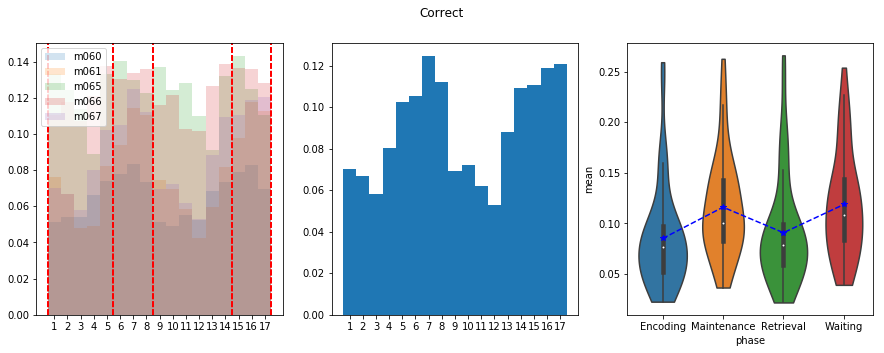

array([[ 0.  , -4.41, -1.8 , -3.99],
       [-4.41,  0.  , -3.26, -0.08],
       [-1.8 , -3.26,  0.  , -3.15],
       [-3.99, -0.08, -3.15,  0.  ]])

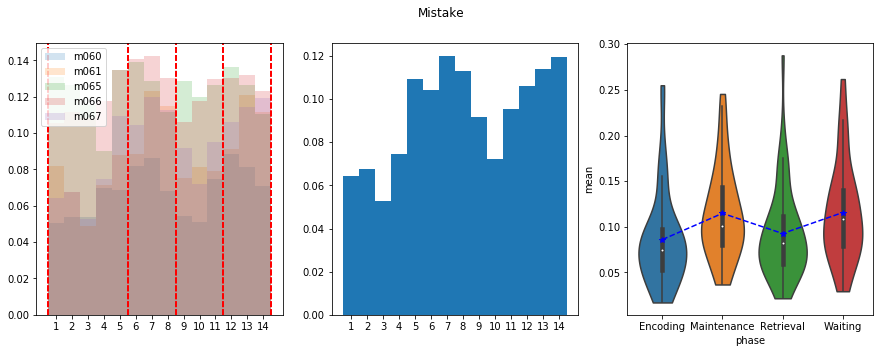

In [8]:
def plot_violins(datatype, metricName, settings):
    for performance in ["Correct", "Mistake"]:
        fig, ax = plt.subplots(ncols=3, figsize=(15,5))
        fig.suptitle(performance)

        intervalOrigIndices = list(dataDB.metaDataFrames['interval_maps'][performance]['index'])
        boundingLines = dataDB.get_phase_bounding_lines(performance)
        phases = dataDB.phases[performance]

        for mousename in sorted(dataDB.mice)[:-1]:
            queryThis = {"datatype" : datatype, "mousename" : mousename, "performance" : performance}  # "direction" : "R"
            rez2D = metric_by_interval(dataDB, queryThis, metricName, 'p', settings)
    #         rez2D = rez2D[..., 0]

            plots_lib.plot_labeled_bars(ax[0], rez2D, intervalOrigIndices, plotLabel=mousename, alpha=0.2)    
            plots_lib.plot_bar_bounds(ax[0], boundingLines)

        rez2DIntervAll = metric_by_interval(dataDB, queryThis, metricName, 'p', settings)
        rez2DPhaseAll = metric_by_phase(dataDB, queryThis, metricName, 'p', settings)
        plots_lib.plot_labeled_bars(ax[1], rez2DIntervAll, intervalOrigIndices)
        plots_lib.plot_labeled_violins(ax[2], rez2DPhaseAll, phases, "phase", metricName, joinMeans=True, printLogP=True)

        ax[0].legend()
        plt.show()
        
settings = {"serial" : True, "metricSettings" : {"max_lag" : 1}}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}
        
plot_violins("deconv", "mean", settings)